# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №1 - Метод k-средних, предобработка признаков


###### <hr\>
**Общая информация**

**Срок сдачи:** 6 марта 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 6 марта, -4 балла после 06:00 13 марта, -6 баллов после 06:00 20 марта

При отправлении ДЗ указывайте фамилию в названии файла.<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

# Первое задание - указать фамилию в имени файла

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Пролог: Модуль sklearn
На наших практических занятиях мы будем использовать [sklearn](http://scikit-learn.org/stable/index.html) (scikit-learn) - наиболее популярный модуль для работы с методами машинного обучения и анализа данных.

Этот модуль регулярно обновляется, расширяется и сопровождается примерами использования тех или иных методов. Помимо самих алгоритмов (например k-средних или линейной регрессии) в нем есть множество вспомогательных функций по работе с данными.

# Туториал: Работа с различными типами признаков

Вспомним какие типы признаков могут встретится при описании объектов исследования и как их представить в доступной для обработки компьтером форме

Типы признаков мы будем рассматривать на примере довольно популярного набора данных [titanic](https://www.kaggle.com/c/titanic/download/train.csv) - информации о выживаемости пассажиров после известной трагедии корабля Titanic.

In [2]:
df_titanic = pd.read_csv('train.csv', sep=',').dropna()
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


## Бинарные признаки
Это признаки с двумя возможными значениями
* Пол (мужской, женский)
* Выжил (да, нет)

На вход в алгоритмы обычно подаются в виде значений `{0, 1}` (реже в виде `{-1, 1}`)

In [3]:
# Здесь все нормально
df_titanic.Survived.value_counts()

1    123
0     60
Name: Survived, dtype: int64

In [4]:
# Тут стоит выполнить переобознаение
df_titanic.Sex.value_counts()

male      95
female    88
Name: Sex, dtype: int64

In [5]:
# Например так
df_titanic.Sex = df_titanic.Sex.replace({'male': 0, 'female': 1})
df_titanic.Sex.value_counts()

0    95
1    88
Name: Sex, dtype: int64

## Вещественные признаки

* Возраст
* Сумма, потраченная на билет
* Количество родственников на борту

Как правило остаются в том же виде или выполняется **нормализация** признаков, т.е. переход к одинаковой шкале, например:

* $\tilde{x} = \frac{x - \text{mean}(x)}{\text{std}(x)}$
* $\tilde{x} = \frac{x - \text{min}(x)}{\text{max}(x) - \text{min}(x)}$

## Категориальные признаки

Принимают значения из *неупорядоченного* множества

* Порт погрузки (C = Cherbourg; Q = Queenstown; S = Southampton)
* Точка отправления (St Louis, MO; Montreal, PQ; .. }
* Точка назначения (Chesterville, ON; Roseville, IL; .. }

Обычно такие признаки кодируют с помощью так называемого One Hot Encoding: </br>
для каждой категории создается бинарная маска-столбец, в которой стоит `1` если значение признака равно значению соответствующей категории категории.

Например, для признака "порт погрзки" создается бинарная макска из трех стобцов для каждого из портов: С, Q, S<br/>
Если пассажир заходил на кораблю в порту Southampton, то его признаковое описание будет соответственно: `[0, 0, 1]`

In [6]:
df_titanic.Embarked.head()

1     C
3     S
6     S
10    S
11    S
Name: Embarked, dtype: object

In [7]:
# Сделать в python это можно несколькими способами:

# 1: Через pandas (не очень рекомендуется)
emb = pd.get_dummies(df_titanic.Embarked, prefix='Embarked', prefix_sep='=')
emb.head()

,Embarked=C,Embarked=Q,Embarked=S
1,1,0,0
3,0,0,1
6,0,0,1
10,0,0,1
11,0,0,1


In [8]:
# 2: Функционал sklearn
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)

emb = df_titanic.loc[:, ['Embarked']].replace({'C': 0, 'Q': 1, 'S': 2}).values
emb_enc = encoder.fit_transform(emb)
emb_enc[:5]

array([[ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.]])

Про другием способы работы с категориальными переменными можно прочитать вот [тут](https://alexanderdyakonov.wordpress.com/2016/08/03/python-%D0%BA%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5-%D0%BF%D1%80%D0%B8%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8/).

## Порядковый признаки

Принимают значения из *упорядоченного* множества

* Класс каюты (1 > 2 > 3)

В зависимости от метода остаются можно оставить в исходном виде или применить OneHotEncoding.

## Текстовые признаки - Bag of words

Для демонстрации возьмем текст стихотворения Блока:

Ночь, улица, фонарь, аптека,<br/>
Бессмысленный и тусклый свет.<br/>
Живи еще хоть четверть века -<br/>
Все будет так. Исхода нет.<br/>

Умрешь - начнешь опять сначала<br/>
И повторится все, как встарь:<br/>
Ночь, ледяная рябь канала,<br/>
Аптека, улица, фонарь.<br/>

Пусть каждая строчка - это будет условный документ. Переведем эти документы в числовое представление по методу мешка слов (Bag Of Words)

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = \
[u'Ночь, улица, фонарь, аптека,',
 u'Бессмысленный и тусклый свет.',
 u'Живи еще хоть четверть века -',
 u'Все будет так. Исхода нет.',
 u'Умрешь - начнешь опять сначала',
 u'И повторится все, как встарь:',
 u'Ночь, ледяная рябь канала,',
 u'Аптека, улица, фонарь.']

In [10]:
vect = CountVectorizer()

bow = vect.fit_transform(corpus)
bow = bow.toarray()
bow.shape

(8, 27)

Получили матрицу размера $8 \times 27$, так как у нас 8 строчек и выделилось 27 униальных слов. Элемент матрицы показывает сколько раз слово встречалось в соответствующем документе.

In [11]:
bow

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1],
       [0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0]])

In [12]:
# Посмотрим какие слова стоят по столбцам
for i, w in enumerate(vect.get_feature_names()):
    print u'столбец %d: %s' % (i, w)

столбец 0: аптека
столбец 1: бессмысленный
столбец 2: будет
столбец 3: века
столбец 4: все
столбец 5: встарь
столбец 6: еще
столбец 7: живи
столбец 8: исхода
столбец 9: как
столбец 10: канала
столбец 11: ледяная
столбец 12: начнешь
столбец 13: нет
столбец 14: ночь
столбец 15: опять
столбец 16: повторится
столбец 17: рябь
столбец 18: свет
столбец 19: сначала
столбец 20: так
столбец 21: тусклый
столбец 22: улица
столбец 23: умрешь
столбец 24: фонарь
столбец 25: хоть
столбец 26: четверть


# Туториал: Имплементация собственного метода

Для решения задач вида "имплементируйте метод X" крайне желательно (но необязательно) реализовывать методы с помощью интерфейса sklearn. Ниже вы увидите пример очень простого **классификатора**. Используйте эти наработи для выполнения задания.

Загрузите [датасет](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) с информацией о характеристиках вина и его качестве. (В метод `pd.read_csv()` можно подать веб-ссылку на данные и пандас их скачает и преобразует в `DataFrame`).

In [13]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

In [14]:
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Наша задача состоит в предсказании целевого признака `quality` по остальным признакам. `quality` - это вещественная переменная (оценка качества от 0 до 10). Упростим себе задачу - создадим новый столбец `quality_cat` по следующим правилам:

* `quality_cat = 1` если `quality > 5` 
* `quality_cat = 0` - иначе 

Таким образом, `quality_cat` характерует "плохое" и "хорошее" вино.

In [15]:
def prepocess_wine(df):
    df.loc[:, 'quality_cat'] = (df.loc[:, 'quality'] > 5).astype(int)
    df = df.drop('quality', axis=1)
    
    return df

In [16]:
df_wine = df_wine.pipe(prepocess_wine)
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_cat
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


Нарисуем распределение хорошего и плохого вина по признаку `alcohol`.

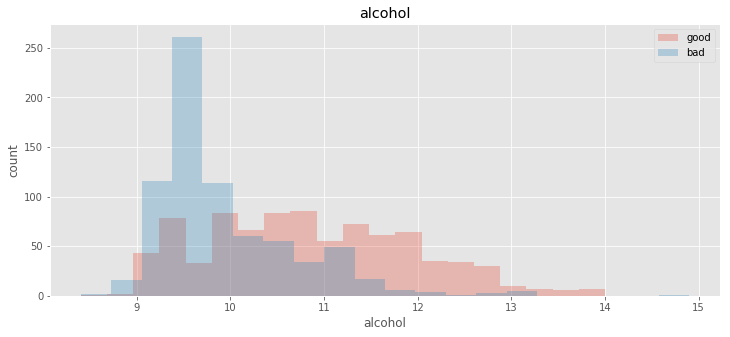

In [17]:
_, ax = plt.subplots(1,1)
df_wine.query('quality_cat == 1').hist('alcohol', alpha=0.3, bins=20, label='good', ax=ax)
df_wine.query('quality_cat == 0').hist('alcohol', alpha=0.3, bins=20, label='bad', ax=ax)
ax.set_xlabel('alcohol')
ax.set_ylabel('count')
plt.legend()

Визуально кажется, что можно найти некоторое пороговое значение признака `alcohol` $\theta$, чтобы хорошо дискриминировать между плохими и хорошим вином:
* Если `alcohol >` $\theta$ - то предсказываем, что вино хорошее
* Если `alcohol <=` $\theta$ - то предсказываем, что вино плохое

Обучаеть классификатор будем очень просто: перебирать значения признака alchol и считать **ошибку** классификации. То значение, где ошибка минимальна и будет оптимальным.

Разделим целевой признак от остальных признаков

In [18]:
X, y = df_wine.iloc[:, :-1].values, df_wine.iloc[:, -1].values

Далее вы увидете пример реализации этого простого классификатора.

In [19]:
from sklearn.base import BaseEstimator, ClassifierMixin

class SimpleClassifier(BaseEstimator, ClassifierMixin): 
    
    def __init__(self):
        """
        Инициализация метода
        """
        
        self.threshold = 0

    def fit(self, X, y=None):
        """
        Выполняет процедуру обучения классификатора. В данном случае - перебор занчения признака alcohol.
        Договоримся, что признак alcohol будет в последнем столбце матрицы X
        """
        
        alcohol = X[:,-1]
        n = float(y.shape[0])
        
        # Задаем пространство поиска
        alco_range = np.arange(alcohol.min(), alcohol.max(), 0.1)
        
        min_error_rate = 1
                
        #  Начинаем поиск
        for theta in alco_range:
            prediction = alcohol > theta
            
            error_rate = sum(prediction != y)/n
            
            if error_rate < min_error_rate:
                min_error_rate = error_rate
                self.threshold = theta  
        
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания класса по обученному порогу
        """
        
        return (X[:,-1] > self.threshold).astype(int)

Обучаем модель

In [20]:
model = SimpleClassifier()
model.fit(X, y)

print 'Оптимальный порог: %f' % model.threshold

Оптимальный порог: 10.000000


Получаем предсказание модели (на обучающей выборке)

In [21]:
y_hat = model.predict(X)

Оценим долю ошибок на обучающей выборке

In [22]:
error_rate = sum(y_hat != y)/float(y.shape[0])
print 'Доля ошибок на обучающей выборке: %f' % error_rate

Доля ошибок на обучающей выборке: 0.295184


## Проверка метода на контрольной выборке

Мы обучили наш метод на данных о красном виде. 

Посмотрим, выполняется ли так же хорошо закономерность между качеством и уровнем алкоголя в белом вине.

In [23]:
df_wine_test = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv',
                           sep=';')

df_wine_test = df_wine_test.pipe(prepocess_wine)
df_wine_test.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_cat
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1


In [24]:
X_test, y_test = df_wine_test.iloc[:, :-1].values, df_wine_test.iloc[:, -1].values
y_hat = model.predict(X_test)

In [25]:
error_rate = sum(y_hat != y_test)/float(y_test.shape[0])
print 'Доля ошибок на контрольной выборке: %f' % error_rate

Доля ошибок на контрольной выборке: 0.312577


Получилось неплохо и это лишь наивный алгоритм на одном признаке! Ну а выводы делайте сами =)

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.</br> При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

#### Задание 1 (5 баллов)

Имплементируйте метод k-means

In [26]:
from scipy.spatial import distance
from sklearn.base import ClusterMixin

class Kmeans(BaseEstimator, ClusterMixin): 
    
    def __init__(self, k=2, metric='euclidean', max_iter=1000, random_state=None):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """
        
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """
        
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)
        
        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])
        
        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))
        
        x_min, x_max = np.asarray((np.amin(X, axis=0), np.amax(X, axis=0)))
        
        for k in xrange(self.k):
            self.centroids[k] = x_min + np.random.rand(1, X.shape[1]) * (x_max - x_min)
        
        for i in xrange(self.max_iter):
            labels = np.argmin([distance.cdist(X, [c], metric=self.metric) for c in self.centroids], axis=0)
            
            if np.count_nonzero([len(np.argwhere(labels == k)) for k in xrange(self.k)]) < self.k:
                labels = np.random.randint(self.k, size=labels.shape)
                labels.T[0, :self.k] = xrange(self.k)
                np.random.shuffle(labels)
            
            self.centroids = np.array([X[labels.T[0] == k].mean(axis=0) for k in xrange(self.k)])
            
            if np.array_equal(labels, self.labels):
                break
            
            self.labels = labels
        
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера
        
        Возвращает метку ближайшего кластера для каждого объекта
        """
        
        return np.argmin([distance.cdist(X, [c], metric=self.metric) for c in self.centroids], axis=0)

### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, желатено испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

In [27]:
from sklearn.datasets import make_blobs

In [28]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

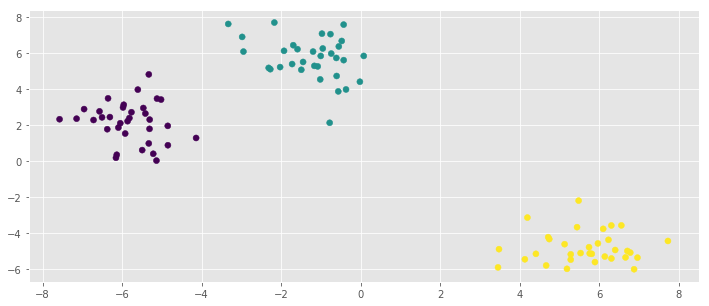

In [29]:
plt.scatter(X[:,0], X[:, 1], c=y)

#### Задание 2 (1 балл) 

Проверьте вашу имплементацию на простых данных

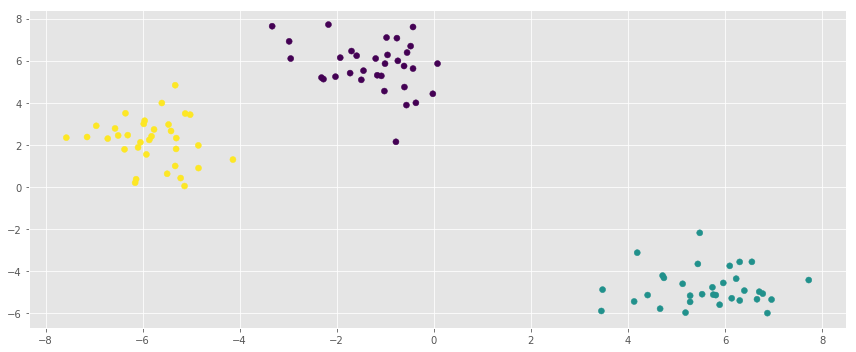

In [30]:
kmeans = Kmeans(k=3)
kmeans.fit(X)
plt.scatter(X[:,0], X[:, 1], c=kmeans.predict(X))
plt.tight_layout()

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.

In [31]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

#### Задание 3 (4 балла)

* Удалите все признаки кроме 36 ключевых слов
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)

In [32]:
df = df_sns.drop(['gradyear', 'gender', 'age', 'friends'], axis=1)
df.head()

,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


In [33]:
for name, values in df.iteritems():
    df[name] = (values - values.mean()) / values.std()

df.head()

,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,-0.332212,-0.357691,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,-0.369909,-0.487306,-0.314193,-0.201473,-0.183029,-0.294788,-0.261526,-0.220399,-0.174905
1,-0.332212,1.060031,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,1.067374,-0.487306,-0.314193,-0.201473,-0.183029,-0.294788,-0.261526,-0.220399,-0.174905
2,-0.332212,1.060031,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,-0.369909,-0.487306,-0.314193,-0.201473,-0.183029,-0.294788,2.027874,-0.220399,-0.174905
3,-0.332212,-0.357691,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,-0.369909,-0.487306,-0.314193,-0.201473,-0.183029,-0.294788,-0.261526,-0.220399,-0.174905
4,-0.332212,-0.357691,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,-0.369909,2.273635,-0.314193,-0.201473,-0.183029,-0.294788,-0.261526,2.285084,2.719271


In [34]:
kmeans = Kmeans(k=9, random_state=0)
kmeans.fit(df)
kmeans.predict(df)

array([[4],
       [0],
       [4],
       ..., 
       [4],
       [4],
       [4]])

In [35]:
df_centroids = pd.DataFrame(data=kmeans.centroids.copy(), columns=df.columns)
df_centroids

,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,-0.020418,-0.010390,-0.015431,-0.081969,-0.000029,0.332586,0.414862,-0.090909,-0.036752,-0.097321,...,0.015312,0.716763,1.105681,0.613846,-0.029702,-0.061271,0.058244,0.130470,0.032863,-0.049525
1,1.290216,1.608159,0.917868,0.036528,0.731358,0.059557,0.069937,1.334452,-0.003597,1.097072,...,0.033884,-0.028729,-0.063016,-0.049018,-0.108245,-0.130750,-0.067863,-0.056717,-0.067274,-0.087746
2,0.138593,0.213102,0.096375,0.002038,0.192048,0.247723,0.409207,0.015129,0.081477,0.091133,...,0.058515,0.604781,0.781678,0.565286,4.158291,4.018586,0.055126,0.097383,0.059311,0.041643
3,0.101162,0.032480,-0.004665,-0.024797,-0.020129,0.085440,-0.003094,-0.032005,-0.002319,-0.034001,...,0.004227,-0.073997,0.028920,0.023620,-0.104543,-0.115394,0.250172,0.339682,0.069100,0.068303
4,-0.187317,-0.220732,-0.111803,-0.140530,-0.114936,-0.109240,-0.118767,-0.145407,-0.096157,-0.158214,...,-0.029836,-0.202777,-0.270786,-0.209720,-0.159860,-0.150368,-0.095316,-0.078561,-0.090504,-0.112790
5,0.346001,0.342359,0.115617,0.069256,0.102988,0.262397,0.150773,0.199542,0.095539,0.765471,...,0.390612,0.638625,0.244265,1.163264,0.179759,0.302003,1.802203,0.972422,1.922709,2.977621
6,0.018373,-0.006953,-0.014789,-0.034856,0.047626,0.054017,0.108282,-0.041401,-0.032925,-0.018872,...,0.029509,0.177806,0.071113,0.139450,-0.046275,-0.074349,0.020734,-0.032983,0.060163,-0.064363
7,-0.112428,0.030674,-0.071795,-0.061522,-0.082363,0.046122,-0.101320,-0.109370,-0.032603,-0.105165,...,-0.012596,-0.117620,-0.081609,-0.013145,-0.166961,-0.144974,-0.022237,0.024649,-0.083797,-0.078689
8,0.468434,0.146613,0.011001,4.212403,0.432643,0.113072,-0.040672,0.094594,2.705004,0.397334,...,0.015995,-0.008535,0.151655,0.084782,-0.036691,-0.004173,-0.034015,0.049178,-0.059332,-0.042600


In [36]:
for k in xrange(kmeans.k):
    print u'В кластере с меткой', k, u'содержится', kmeans.labels[kmeans.labels == k].size, u'профилей учеников старшей школы США и преобладает признак', df_centroids.loc[k].argmax()

В кластере с меткой 0 содержится 3878 профилей учеников старшей школы США и преобладает признак shopping
В кластере с меткой 1 содержится 2258 профилей учеников старшей школы США и преобладает признак football
В кластере с меткой 2 содержится 842 профилей учеников старшей школы США и преобладает признак hollister
В кластере с меткой 3 содержится 476 профилей учеников старшей школы США и преобладает признак bible
В кластере с меткой 4 содержится 19057 профилей учеников старшей школы США и преобладает признак blonde
В кластере с меткой 5 содержится 885 профилей учеников старшей школы США и преобладает признак kissed
В кластере с меткой 6 содержится 1152 профилей учеников старшей школы США и преобладает признак hot
В кластере с меткой 7 содержится 752 профилей учеников старшей школы США и преобладает признак marching
В кластере с меткой 8 содержится 700 профилей учеников старшей школы США и преобладает признак softball


In [37]:
for k, row in df_centroids.iterrows():
    if any(row > 0):
        print u'В кластере с меткой', k, u'ряд признаков', tuple(row[row > 0].index), u'достигает значения выше среднего.\n'
    else:
        print u'В кластере с меткой', k, u'ни один из признаков не достигает значения выше среднего.\n'

В кластере с меткой 0 ряд признаков ('swimming', 'cheerleading', 'cute', 'dance', 'music', 'rock', 'god', 'church', 'jesus', 'hair', 'dress', 'blonde', 'mall', 'shopping', 'clothes', 'die', 'death', 'drunk') достигает значения выше среднего.

В кластере с меткой 1 ряд признаков ('basketball', 'football', 'soccer', 'softball', 'volleyball', 'swimming', 'cheerleading', 'baseball', 'sports', 'music', 'rock', 'church', 'blonde') достигает значения выше среднего.

В кластере с меткой 2 ряд признаков ('basketball', 'football', 'soccer', 'softball', 'volleyball', 'swimming', 'cheerleading', 'baseball', 'tennis', 'sports', 'cute', 'sex', 'sexy', 'hot', 'kissed', 'dance', 'music', 'rock', 'god', 'hair', 'dress', 'blonde', 'mall', 'shopping', 'clothes', 'hollister', 'abercrombie', 'die', 'death', 'drunk', 'drugs') достигает значения выше среднего.

В кластере с меткой 3 ряд признаков ('basketball', 'football', 'swimming', 'dance', 'band', 'music', 'rock', 'god', 'church', 'jesus', 'bible', 'hair

In [38]:
for k, row in df_centroids.iterrows():
    if any(row > 1):
        print u'В кластере с меткой', k, u'у некоторых признаков', tuple(row[row > 1].index), u'отклонение вверх от средних значений превышает стандартное.\n'

В кластере с меткой 0 у некоторых признаков ('shopping',) отклонение вверх от средних значений превышает стандартное.

В кластере с меткой 1 у некоторых признаков ('basketball', 'football', 'baseball', 'sports') отклонение вверх от средних значений превышает стандартное.

В кластере с меткой 2 у некоторых признаков ('hollister', 'abercrombie') отклонение вверх от средних значений превышает стандартное.

В кластере с меткой 3 у некоторых признаков ('god', 'church', 'jesus', 'bible') отклонение вверх от средних значений превышает стандартное.

В кластере с меткой 5 у некоторых признаков ('sex', 'kissed', 'music', 'rock', 'hair', 'clothes', 'die', 'drunk', 'drugs') отклонение вверх от средних значений превышает стандартное.

В кластере с меткой 6 у некоторых признаков ('sexy', 'hot') отклонение вверх от средних значений превышает стандартное.

В кластере с меткой 7 у некоторых признаков ('band', 'marching') отклонение вверх от средних значений превышает стандартное.

В кластере с меткой 8

**Интерпретация кластеров**

Кластер с меткой 0 включает профили учеников, увлекающихся шопингом. Значительная часть из них предпочитает танцы, плавание и черлидинг, что говорит о преобладании женского пола среди представителей данного кластера.

Кластер с меткой 1 включает профили учеников, увлекающихся преимущественно командными видами спорта. Особый интерес для них представляют более травмоопасные спортивные игры с мячом.

Кластер с меткой 2 включает профили учеников, которые носят брендовую одежду.

Кластер с меткой 3 включает профили набожных учеников, скорее всего из семей, ведущих активную религиозную жизнь.

Кластер с меткой 4 очень большой - плохо интерпретируется. Можно сказать, что он содержит фейковые профили, а также профили тех учеников, которые мало чем увлекаются серьёзно.

Кластер с меткой 5 включает профили учеников, увлекающихся рок-музыкой и подобными элементами культуры.

Кластер с меткой 6 включает профили учеников, увлекающихся контентом откровенного содержания.

Кластер с меткой 7 включает профили учеников, увлекающихся слётами, групповыми выездами, походами и лагерями.

Кластер с меткой 8 включает профили учеников, увлекающихся менее травмоопасными видами спорта.